<a href="https://colab.research.google.com/github/benasphy/Deep-Learning/blob/main/Autoencoder_for_fraud_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.9136 - val_loss: 0.6145
Epoch 2/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.6111 - val_loss: 0.5106
Epoch 3/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.5325 - val_loss: 0.4789
Epoch 4/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4904 - val_loss: 0.4581
Epoch 5/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4644 - val_loss: 0.4444
Epoch 6/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.4546 - val_loss: 0.4356
Epoch 7/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.4436 - val_loss: 0.4296
Epoch 8/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.4416 - val_loss: 0.4252
Epoch 9/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - loss: 0.4354 - val_loss: 0.4226
Epoch 10/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4272 - val_loss: 0.4194
Epoch 11/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - loss: 0.4218 - val_loss: 0.4201
Epoch 12/20
800/800 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step

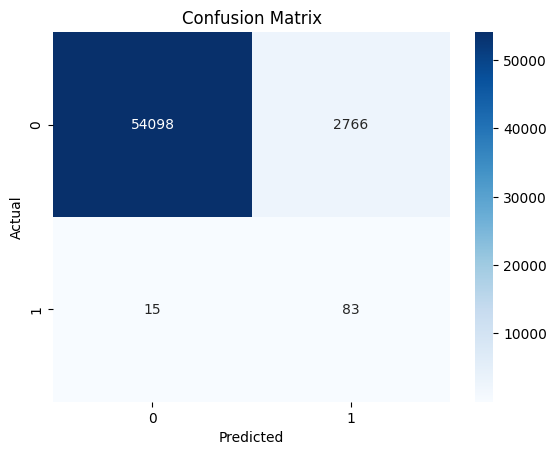

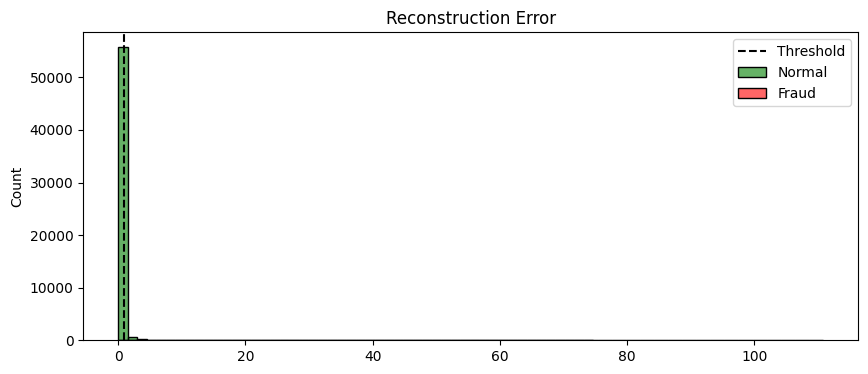

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step

🔎 Example Transaction Prediction
True label: Not Fraud
Reconstruction error: 0.66668
Prediction: Not Fraud ✅


In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense

# Load dataset
df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv")

# Separate features and labels
X = df.drop(['Time', 'Class'], axis=1)
y = df['Class']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Use ONLY legitimate transactions to train the autoencoder
X_train_normal = X_train[y_train == 0]

# Define Autoencoder architecture
input_dim = X_train_normal.shape[1]
input_layer = Input(shape=(input_dim,))
encoded = Dense(16, activation='relu')(input_layer)
encoded = Dense(8, activation='relu')(encoded)
decoded = Dense(16, activation='relu')(encoded)
output_layer = Dense(input_dim, activation='linear')(decoded)

autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(optimizer='adam', loss='mse')

# Train the autoencoder
history = autoencoder.fit(
    X_train_normal, X_train_normal,
    epochs=20,
    batch_size=256,
    shuffle=True,
    validation_split=0.1,
    verbose=1
)

# Reconstruct test data
X_test_pred = autoencoder.predict(X_test)
mse = np.mean(np.power(X_test - X_test_pred, 2), axis=1)

# Set threshold using training MSE
threshold = np.percentile(mse, 95)
print(f"Reconstruction error threshold: {threshold}")

# Predict fraud if error > threshold
y_pred = (mse > threshold).astype(int)

# Evaluation
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

print("ROC AUC Score:", roc_auc_score(y_test, mse))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title('Confusion Matrix')
plt.show()

# Plot reconstruction error distribution
plt.figure(figsize=(10, 4))
sns.histplot(mse[y_test == 0], label='Normal', bins=50, color='green', alpha=0.6)
sns.histplot(mse[y_test == 1], label='Fraud', bins=50, color='red', alpha=0.6)
plt.axvline(threshold, color='black', linestyle='--', label='Threshold')
plt.legend()
plt.title('Reconstruction Error')
plt.show()

# 🔍 Example: Test a single transaction (taken from test set)
sample_index = 1  # you can try different indexes
sample = X_test[sample_index].reshape(1, -1)
true_label = y_test.iloc[sample_index]

# Reconstruct and calculate reconstruction error
sample_pred = autoencoder.predict(sample)
sample_mse = np.mean(np.power(sample - sample_pred, 2))

# Compare with threshold
is_fraud = sample_mse > threshold

print("\n🔎 Example Transaction Prediction")
print("True label:", "Fraud" if true_label == 1 else "Not Fraud")
print(f"Reconstruction error: {sample_mse:.5f}")
print("Prediction:", "Fraud 🚨" if is_fraud else "Not Fraud ✅")